In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() 
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = F.softplus(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z 


In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape(-1, 1, 28, 28)

In [5]:
class VarianceAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VarianceAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [28]:
def train(autoencoder, train_data, val_data, epochs=200, patience=5): 
    optimizer = torch.optim.Adam(autoencoder.parameters())
    autoencoder.to(DEVICE)

    # automatic stopping
    best_val_loss = float('inf')
    no_improvement_count = 0
    best_model_state = None

    for epoch in range(epochs):
        epoch_loss = 0

        autoencoder.train()
        for x, _ in train_data:
            x = x.to(DEVICE)
            optimizer.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            optimizer.step() 
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_data)}")

        with torch.no_grad():
            autoencoder.eval()
            val_loss = 0
            for x, _ in val_data:
                x = x.to(DEVICE)
                x_hat = autoencoder(x)
                loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
                val_loss += loss.item()

            val_loss /= len(val_data)
            print(f"Validation Loss: {val_loss}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_count = 0
                best_model_state = autoencoder.state_dict()
            else:
                no_improvement_count += 1

            # early stopping
            if no_improvement_count >= patience:
                print(f"Stopping early at epoch {epoch+1}")
                break


    autoencoder.load_state_dict(best_model_state)
    return autoencoder

In [24]:
latent_dims = 2

data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
# split data into train and validation
train_data, val_data = torch.utils.data.random_split(data, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

vae = VarianceAutoencoder(latent_dims).to(DEVICE)

In [29]:
vae = train(vae, train_loader, val_loader)

Epoch 1/200, Loss: 5286.512308808544
Validation Loss: 5239.381759450405
Epoch 2/200, Loss: 5228.5427327265825
Validation Loss: 5172.628013127966
Epoch 3/200, Loss: 5188.712076406649
Validation Loss: 5126.992851933346
Epoch 4/200, Loss: 5151.51532154132
Validation Loss: 5106.7609925089
Epoch 5/200, Loss: 5122.639092096587
Validation Loss: 5081.600412875791
Epoch 6/200, Loss: 5098.352801310742
Validation Loss: 5051.514237415941
Epoch 7/200, Loss: 5076.075375139866
Validation Loss: 5044.811701907387
Epoch 8/200, Loss: 5059.274622612292
Validation Loss: 5026.881811986996
Epoch 9/200, Loss: 5039.996095623202
Validation Loss: 5011.9163632936115
Epoch 10/200, Loss: 5024.060832226063
Validation Loss: 4989.277978052067
Epoch 11/200, Loss: 5012.267614340233
Validation Loss: 4990.9052734375
Epoch 12/200, Loss: 4995.847360284127
Validation Loss: 4974.880667770965
Epoch 13/200, Loss: 4980.925450317695
Validation Loss: 4989.663172468355
Epoch 14/200, Loss: 4970.782672384511
Validation Loss: 4953.022

In [30]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        # print(i)
        z = autoencoder.encoder(x.to(DEVICE))
        z = z.detach().cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i == num_batches-1:
            plt.colorbar()
            break

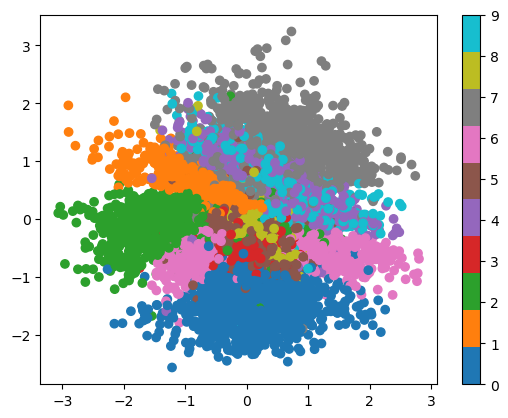

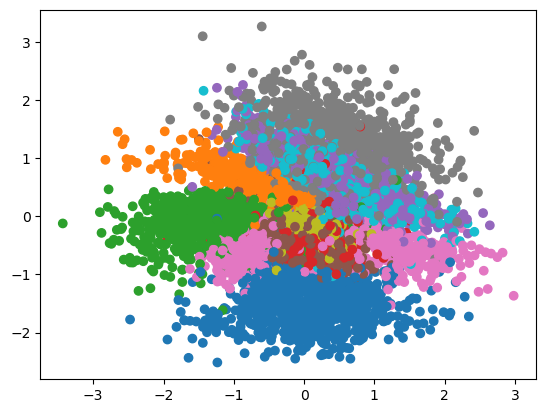

In [32]:
plot_latent(vae, train_loader)
plt.show()

plot_latent(vae, val_loader)
plt.show()
